# Parques isochrone test

This notebook takes script-21-project-Volvo's code (Just for parques, up to nearest) to __confirm the number of parques inside a random 15-min node isochrone.__

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Nearest parques test

### Required data to calculate parques nearest

In [2]:
parameters = {'Parques':{'Area verde':{'odc_parques':[9321]} ########## Volvo: AGREGAR DE BD, 
                                                          ########## Se le asignó el code 9321, correspondiente a 'Activities of amusement parks and theme parks'
                                                          ########## Fuente del code elegido: International Standard Industrial Classification of all Economic Activities, Rev.4
                                                          ########## https://unstats.un.org/unsd/publication/seriesm/seriesm_4rev4e.pdf
                        }
             }


city = 'Guadalajara'
# ---------------------------- BD DATA REQUIRED ----------------------------
# Area of interest (city)
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'

# Network data (nodes and edges table for distance analysis,
# also used to generate the network G with which the nearest OSMID is assigned to each poi)
network_schema = 'osmnx'
nodes_table = 'nodes'
edges_table = 'edges_speed'

# Points of interest - Espacio publico (Parques) ### Exclusive project Volvo
parques_schema = 'espacios_publicos' 
parques_table = 'ep_amg'

# ---------------------------- ANALYSIS AND OUTPUT OPTIONS ----------------------------
# Network distance method used in function pois_time. (If length, assumes pedestrian speed of 4km/hr.)
prox_measure = 'time_min' # Must pass 'length' or 'time_min'

# Count available amenities at given time proximity (minutes)?
count_pois = (True,15) # Must pass a tupple containing a boolean (True or False) and time proximity of interest in minutes (Boolean,time)

In [3]:
####################################################################################################################################
# NEW
# Project Volvo includes 'parques', which are in OdC's DB
####################################################################################################################################
def get_parques_pois(parques_schema,parques_table,code):
    # This function creates parques points of interest out of vertices of parques found in db (schema>table)

    # Download parques pois
    query = f"SELECT * FROM {parques_schema}.{parques_table}"
    gdf = aup.gdf_from_query(query, geometry_col='geometry')
    gdf = gdf.to_crs("EPSG:4326")

    # Get vertices coordinates
    gdf_coords = gdf.geometry.get_coordinates()

    # Merge back with gdf containing data
    gdf_coords_data = pd.merge(gdf_coords,gdf,left_index=True,right_index=True)

    # Drop poly geometry 
    df_coords_data = gdf_coords_data.drop(columns=['geometry'])
    # Set points geometry
    gdf_2 = gpd.GeoDataFrame(df_coords_data, 
                             geometry=gpd.points_from_xy(df_coords_data.x, df_coords_data.y),
                             crs='EPSG:4326')
    
    # Format
    gdf_2.drop(columns=['x','y'],inplace=True)
    gdf_2.reset_index(inplace=True)
    gdf_2.rename(columns={'index':'polygon_id'},inplace=True)

    # Project Volvo filter
    # Tipos
    tipos = ['Parque','Espacio verde vecinal', 'Plaza', 'Área natural', 'Área natural protegida']
    gdf_f1 = gdf_2.loc[gdf_2.Tipo.isin(tipos)]
    # Usos
    gdf_f2 = gdf_f1.loc[gdf_f1.Uso == 'Uso recreativo']

    # Proxanalysis filter
    #code_pois = gdf_f2.set_crs("EPSG:4326")
    gdf_f2['code'] = code
    code_pois = gdf_f2[['polygon_id','code','geometry']]
    code_pois['code'] = code_pois['code'].astype('int64')

    code_pois = code_pois.drop_duplicates()
    
    return code_pois

### Calculate parques nearest

In [4]:
# Download area of interest
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mun_gdf = mun_gdf.set_crs("EPSG:4326")
aoi = mun_gdf.dissolve()

# Download Network used to calculate nearest note to each poi
G, nodes, edges = aup.graph_from_hippo(aoi, schema=network_schema, edges_folder=edges_table, nodes_folder=nodes_table)

In [6]:
# PREP. FOR ANALYSIS
i = 0
# PREP. FOR ANALYSIS - List of columns used to deliver final format
analysis_cols = []

eje = 'Parques'
for amenity in parameters[eje]:
    for source in parameters[eje][amenity]:

        analysis_cols.append(source)
        # PREP. FOR ANALYSIS - If counting pois, append corresponding column (count_col formated example: 'denue_preescolar_15min')
        if count_pois[0]:
            count_col = f'{source}_{count_pois[1]}min'
            analysis_cols.append(count_col)
        
        # ANALYSIS - Select source points of interest (concats all data of current source's codes in source_pois)
        source_pois = gpd.GeoDataFrame()
        for code in parameters[eje][amenity][source]:
            if source[0] == 'o':
                print(f'--- Loading source pois code {code} from db.')
                code_pois = get_parques_pois(parques_schema,parques_table,code)
                source_pois = pd.concat([source_pois,code_pois])
                print(f'--- Loaded and filtered source pois code {code} from db.')

        print(f"--- {source_pois.shape[0]} {source} vertexes for {len(list(source_pois.polygon_id.unique()))} unique sources. Analysing source pois proximity to nodes.")

        # ANALYSIS - Calculate time data from nodes to source
        ####################################################################################################################################################################################
        # FUNCTION aup.pois_time
        # Calculates times from nodes to source (source_nodes_time = aup.pois_time(G, nodes, edges, source_pois, source, prox_measure,count_pois))
        # analysis function being used: def pois_time(G, nodes, edges, pois, poi_name, prox_measure,count_pois=(False,0)):
        pois = source_pois.copy()
        poi_name = source
        ##########################################################################################
        # STEP 1: NEAREST. 
        # Finds and assigns nearest node OSMID to each point of interest.
           
        # Defines projection for downloaded data
        pois = pois.set_crs("EPSG:4326")
        nodes = nodes.set_crs("EPSG:4326")
        edges = edges.set_crs("EPSG:4326")
        
        # In case there are no amenities of the type in the city, prevents it from crashing if len = 0
        if len(pois) == 0:
            nodes_time = nodes.copy()
    
            # Format
            nodes_time.reset_index(inplace=True)
            nodes_time = nodes_time.set_crs("EPSG:4326")
    
            # As no amenities were found, output columns are set to nan.
            nodes_time['time_'+poi_name] = np.nan # Time is set to np.nan.
            print(f"0 {poi_name} found. Time set to np.nan for all nodes.")
            if count_pois[0]: 
                nodes_time[f'{poi_name}_{count_pois[1]}min'] = np.nan # If requested pois_count, value is set to np.nan.
                print(f"0 {poi_name} found. Pois count set to nan for all nodes.")
                nodes_time = nodes_time[['osmid','time_'+poi_name,f'{poi_name}_{count_pois[1]}min','x','y','geometry']]
                #return nodes_time
            else:
                nodes_time = nodes_time[['osmid','time_'+poi_name,'x','y','geometry']]
                #return nodes_time
        
        else:
            ### Find nearest osmnx node for each DENUE point.
            nearest = aup.find_nearest(G, nodes, pois, return_distance= True)
            nearest = nearest.set_crs("EPSG:4326")
            print(f"Found and assigned nearest node osmid to each {poi_name}.")

            ##########################################################################################
            # ADDITIONAL STEP
            # Since right now 'nearest' has all osmnx nodes closest to a given polygon vertex, one osmnx node might be assigned to 2 or more polygon vertexes of the SAME polygon.
            # If we leave it like that, that node will count as n points of interest even if it is just close to 1 polygon.
            # This step filters for the minimum distance (distance_node) from osmid to each polygon vertex, 
            # so that if one node is close to 5 vertexes of 1 polygon, there is only 1 row poi, not 5.
    
            # Group by node (osmid) and polygon (green space) considering only the closest vertex (min)
            groupby = nearest.groupby(['osmid','polygon_id']).agg({'distance_node':np.min})
    
            # Turns back into gdf merging back with nodes geometry
            geom_gdf = nodes.reset_index()[['osmid','geometry']]
            
            groupby.reset_index(inplace=True)
            nearest = pd.merge(groupby,geom_gdf,on='osmid',how='left')
            nearest = gpd.GeoDataFrame(nearest, geometry="geometry")

            # Filters for pois assigned to nodes at a maximum distance of 30 meters 
            # Before filtering, (nearest.distance_node.mean() = 17.06105077021867m but max of 248.52261m, too far.
            nearest = nearest.loc[nearest.distance_node <= 30]

--- Loading source pois code 9321 from db.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


--- Loaded and filtered source pois code 9321 from db.
--- 57635 odc_parques vertexes for 2497 unique sources. Analysing source pois proximity to nodes.
Found and assigned nearest node osmid to each odc_parques.


## Isochrone test 1 (osmid chosen in QGIS because had high odc_parques_15min)

### Isochrone generation

In [6]:
node_osmid = 1675029867

In [7]:
# def calculate_isochrone(G, center_node, trip_time, dist_column, subgraph=False):
isochrone = aup.calculate_isochrone(G, node_osmid, 15, 'time_min', subgraph=False)

# Create gdf
iso_gdf = gpd.GeoDataFrame()
iso_gdf.loc[0,'node'] = node_osmid
iso_gdf.loc[0,'geometry'] = isochrone
iso_gdf.set_crs("EPSG:4326",inplace=True)

# Show
print(iso_gdf.crs)
iso_gdf.head(1)

EPSG:4326


,node,geometry
0,1.675030e+09,"POLYGON ((-103.39183 20.74716, -103.40052 20.7..."


<Axes: >

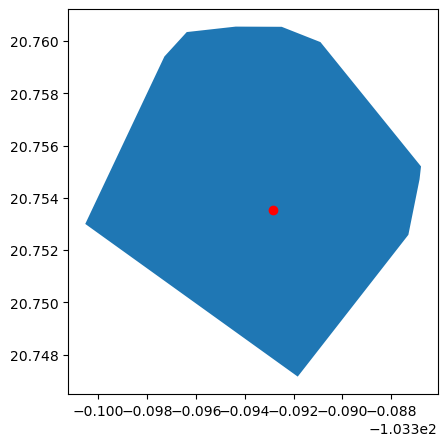

In [8]:
test = nodes.reset_index()
node = test.loc[test.osmid == node_osmid]

# Show (plot)
fig,ax=plt.subplots(figsize=(5,5))
iso_gdf.plot(ax=ax,zorder=0)
node.plot(ax=ax,zorder=1,c='red')

In [9]:
local_save_dir = '../../../data/external/temporal_fromjupyter/volvo/isochrone_test.gpkg'
iso_gdf.to_file(local_save_dir)

### Parques on isochrone test

In [10]:
isochrone_pois = gpd.sjoin(nearest,iso_gdf,how='inner')

print(isochrone_pois.shape)
isochrone_pois.head(1)

(72, 6)


,osmid,polygon_id,distance_node,geometry,index_right,node
2201,1674704950,937,12.599395,POINT (-103.39053 20.75252),0,1.675030e+09


<Axes: >

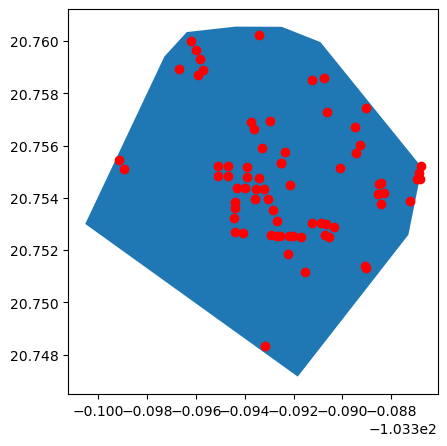

In [11]:
fig,ax=plt.subplots(figsize=(5,5))

iso_gdf.plot(ax=ax,zorder=0)
isochrone_pois.plot(ax=ax,zorder=1,c='red')

In [12]:
len(list(isochrone_pois.polygon_id.unique()))

25

In [13]:
isochrone_pois.to_file('../../../data/external/temporal_fromjupyter/volvo/isochrone_nearest.gpkg')

## Isochrone test 2 (higher odc_parques_15min after fixing error)

In [7]:
nodes_local_save_dir = '../../../data/external/temporal_fromjupyter/volvo/proxanalysis_volvo_2024_nodes.gpkg'
proxanalysis_volvo_2024_nodes = gpd.read_file(nodes_local_save_dir)

# Show
print(proxanalysis_volvo_2024_nodes.shape)
proxanalysis_volvo_2024_nodes.head(1)

(184338, 30)


,osmid,denue_guarderias,denue_guarderias_15min,denue_preescolar,denue_preescolar_15min,denue_primaria,denue_primaria_15min,denue_secundaria,denue_secundaria_15min,clues_primer_nivel,...,denue_museos_15min,denue_bibliotecas,denue_bibliotecas_15min,denue_bancos,denue_bancos_15min,x,y,odc_parques,odc_parques_15min,geometry
0,28751344,13.128475,1.0,1.80726,5.0,7.275387,8.0,3.88002,2.0,7.275387,...,0.0,15.68526,0.0,12.983204,2.0,-103.306309,20.711533,5.763263,6,POINT (-103.30631 20.71153)


In [28]:
idx = proxanalysis_volvo_2024_nodes['odc_parques_15min'].max()
higher_parques = proxanalysis_volvo_2024_nodes.loc[proxanalysis_volvo_2024_nodes['odc_parques_15min'] == idx]
higher_parques = higher_parques

# Show
print(higher_parques.shape)
higher_parques.head(1)

(1, 30)


,osmid,denue_guarderias,denue_guarderias_15min,denue_preescolar,denue_preescolar_15min,denue_primaria,denue_primaria_15min,denue_secundaria,denue_secundaria_15min,clues_primer_nivel,...,denue_museos_15min,denue_bibliotecas,denue_bibliotecas_15min,denue_bancos,denue_bancos_15min,x,y,odc_parques,odc_parques_15min,geometry
94585,4663817629,52.205267,0.0,12.249914,1.0,15.867175,0.0,23.512945,0.0,19.231113,...,0.0,61.214214,0.0,49.956895,0.0,-103.350764,20.494728,0.0,65,POINT (-103.35076 20.49473)


In [30]:
higher_parques = higher_parques[['osmid', 
                                 'denue_guarderias_15min','denue_preescolar_15min', 'denue_primaria_15min', 'denue_secundaria_15min',
                                 'clues_primer_nivel_15min','denue_farmacias_15min', 
                                 'odc_parques_15min',
                                 'sip_cancha_15min','sip_unidad_deportiva_15min',
                                 'denue_cines_15min', 'denue_museos_15min','denue_bibliotecas_15min',
                                 'denue_bancos_15min',
                                 'geometry']]
higher_parques

,osmid,denue_guarderias_15min,denue_preescolar_15min,denue_primaria_15min,denue_secundaria_15min,clues_primer_nivel_15min,denue_farmacias_15min,odc_parques_15min,sip_cancha_15min,sip_unidad_deportiva_15min,denue_cines_15min,denue_museos_15min,denue_bibliotecas_15min,denue_bancos_15min,geometry
94585,4663817629,0.0,1.0,0.0,0.0,0.0,0.0,65,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-103.35076 20.49473)


### Isochrone 2 generation

In [9]:
node_osmid = higher_parques['osmid'].unique()[0]
node_osmid

4663817629

In [10]:
# def calculate_isochrone(G, center_node, trip_time, dist_column, subgraph=False):
isochrone = aup.calculate_isochrone(G, node_osmid, 15, 'time_min', subgraph=False)

# Create gdf
iso_gdf_2 = gpd.GeoDataFrame()
iso_gdf_2.loc[0,'node'] = node_osmid
iso_gdf_2.loc[0,'geometry'] = isochrone
iso_gdf_2.set_crs("EPSG:4326",inplace=True)

# Show
print(iso_gdf_2.crs)
iso_gdf_2.head(1)

EPSG:4326


,node,geometry
0,4.663818e+09,"POLYGON ((-103.34713 20.49029, -103.35441 20.4..."


<Axes: >

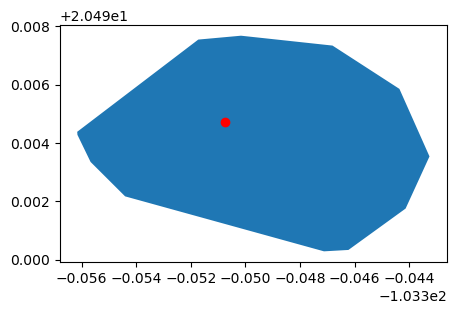

In [11]:
test = nodes.reset_index()
node = test.loc[test.osmid == node_osmid]

# Show (plot)
fig,ax=plt.subplots(figsize=(5,5))
iso_gdf_2.plot(ax=ax,zorder=0)
node.plot(ax=ax,zorder=1,c='red')

In [12]:
local_save_dir = '../../../data/external/temporal_fromjupyter/volvo/isochrone_test_2.gpkg'
iso_gdf_2.to_file(local_save_dir)

### Parques on isochrone 2 test

In [13]:
isochrone_2_pois = gpd.sjoin(nearest,iso_gdf_2,how='inner')

print(isochrone_2_pois.shape)
isochrone_2_pois.head(1)

(166, 6)


,osmid,polygon_id,distance_node,geometry,index_right,node
3118,1750011263,2847,5.577534,POINT (-103.35442 20.49235),0,4.663818e+09


<Axes: >

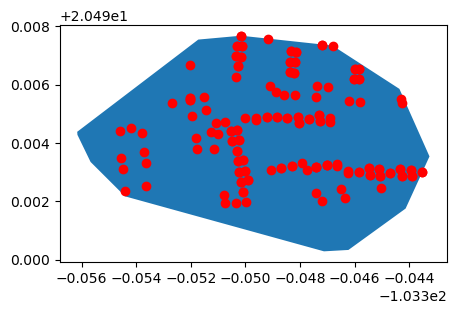

In [15]:
fig,ax=plt.subplots(figsize=(5,5))

iso_gdf_2.plot(ax=ax,zorder=0)
isochrone_2_pois.plot(ax=ax,zorder=1,c='red')

In [19]:
# proxanalysis ['odc_parques_15min'].max() = 65
len(list(isochrone_2_pois.polygon_id.unique()))

56

In [20]:
isochrone_2_pois.to_file('../../../data/external/temporal_fromjupyter/volvo/isochrone_2_nearest.gpkg')